# Boosting на Statlog (Heart): EDA, Grid/Random/Optuna, ROC, сравнение метрик

**Цели:**

1) Загрузить датасет UCI Statlog (Heart) и подготовить целевую переменную.  
2) Провести краткий EDA.  
3) Построить пайплайны `sklearn` для XGBoost, LightGBM, CatBoost.  
4) Настроить гиперпараметры: GridSearch, RandomizedSearch; показать пример Optuna.  
5) Оценить по метрикам Accuracy, F1, Precision, Recall, Specificity, ROC AUC; построить ROC.  
6) Сохранить лучшие модели; сформировать итоговый отчёт.



In [1]:
!pip install -q ucimlrepo xgboost lightgbm catboost scikit-learn matplotlib seaborn joblib optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.4 MB/s eta 0:00:00


In [2]:
heart = fetch_ucirepo(id=145)  # Statlog (Heart)
X = heart.data.features
y = heart.data.targets  # DataFrame с одной колонкой

df = pd.concat([X, pd.Series(y.values.ravel(), name='target')], axis=1)

# Приведение target к 0/1: в оригинале 1 = здоров, 2 = болезнь
df['target'] = df['target'].map({1: 0, 2: 1}).astype(int)

df.head()


,age,sex,chest-pain,rest-bp,serum-chol,fasting-blood-sugar,electrocardiographic,max-heart-rate,angina,oldpeak,slope,major-vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


## Немножко еды

In [3]:
print("Размер датасета:", df.shape)
print("\nПризнаки:\n", df.columns.tolist())
print("\nРаспределение целевой переменной:")
print(df["target"].value_counts())

# Проверка типов и пропусков
print("\nТипы данных:")
print(df.dtypes)

print("\nПропущенные значения:")
print(df.isnull().sum())


Размер датасета: (270, 14)

Признаки:
 ['age', 'sex', 'chest-pain', 'rest-bp', 'serum-chol', 'fasting-blood-sugar', 'electrocardiographic', 'max-heart-rate', 'angina', 'oldpeak', 'slope', 'major-vessels', 'thal', 'target']

Распределение целевой переменной:
target
0    150
1    120
Name: count, dtype: int64

Типы данных:
age                     float64
sex                     float64
chest-pain              float64
rest-bp                 float64
serum-chol              float64
fasting-blood-sugar     float64
electrocardiographic    float64
max-heart-rate          float64
angina                  float64
oldpeak                 float64
slope                   float64
major-vessels           float64
thal                    float64
target                    int64
dtype: object

Пропущенные значения:
age                     0
sex                     0
chest-pain              0
rest-bp                 0
serum-chol              0
fasting-blood-sugar     0
electrocardiographic    0
max-heart-

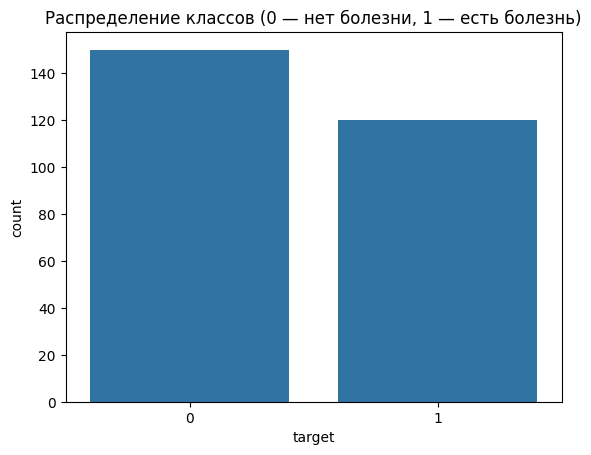

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение по классам
sns.countplot(data=df, x="target")
plt.title("Распределение классов (0 — нет болезни, 1 — есть болезнь)")
plt.show()


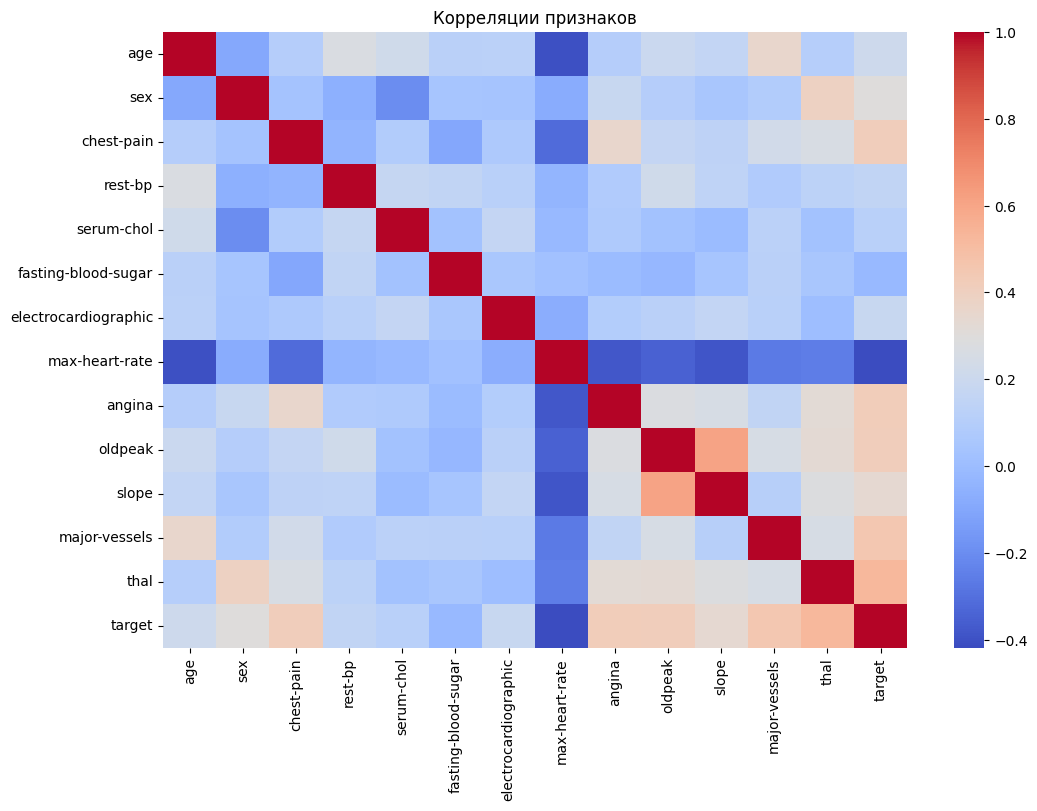

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Корреляции признаков")
plt.show()

# Что видно - целевой признак не со всеми хорошо скоррелирован, thal (Талассемия - наследственное заболевание крови)
# показывает хорошую корреляцию.

## Готовим данные

In [6]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((216, 13), (54, 13))

## Настраиваем параметры модели и поиска по сетке

In [7]:
common_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
]

pipelines = {
    "XGBoost": Pipeline(common_steps + [
        ('model', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            tree_method='hist'  # быстрее на CPU
        ))
    ]),
    "LightGBM": Pipeline(common_steps + [
        ('model', LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "CatBoost": Pipeline(common_steps + [
        ('model', CatBoostClassifier(
            loss_function='Logloss',
            random_state=42,
            verbose=0
        ))
    ]),
}

param_grids = {
    "XGBoost": {
        'model__n_estimators': [200, 400, 800],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.7, 1.0],
        'model__colsample_bytree': [0.7, 1.0],
        'model__min_child_weight': [1, 3, 5],
    },
    "LightGBM": {
        'model__n_estimators': [200, 400, 800],
        'model__num_leaves': [15, 31, 63],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.7, 1.0],
        'model__colsample_bytree': [0.7, 1.0],
        'model__min_child_samples': [5, 20, 40],
    },
    "CatBoost": {
        'model__iterations': [300, 600, 1000],
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__random_strength': [0, 1, 2],
    },
}


## Обучаемся

In [8]:
SEARCH_MODE = "random"  # "grid" или "random"
N_JOBS = -1
CV_FOLDS = 5
N_ITER_RANDOM = 25  # число комбинаций для RandomizedSearchCV
SCORING = 'f1'      # основной скоринг для подбора


In [9]:
#дальше долгое, потому что здоровая сетка и рандом серч
best_models = {}
results_rows = []

# убедимся, что X_test подаём с колонками
X_test_df = pd.DataFrame(X_test, columns=X.columns)

for name, pipe in pipelines.items():
    params = param_grids[name]
    if SEARCH_MODE == "grid":
        search = GridSearchCV(
            pipe, param_grid=params, scoring=SCORING,
            cv=CV_FOLDS, n_jobs=N_JOBS, verbose=0
        )
    else:
        # RandomizedSearch: перебираем случайные подмножества сетки
        search = RandomizedSearchCV(
            pipe, param_distributions=params, scoring=SCORING,
            cv=CV_FOLDS, n_jobs=N_JOBS, verbose=0,
            n_iter=N_ITER_RANDOM, random_state=42
        )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_models[name] = best_model
    joblib.dump(best_model, f"{name}_best_model.pkl")

    y_pred = best_model.predict(X_test_df)
    y_proba = best_model.predict_proba(X_test_df)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp)

    cv_f1 = cross_val_score(best_model, X, y, cv=CV_FOLDS, scoring='f1').mean()
    cv_acc = cross_val_score(best_model, X, y, cv=CV_FOLDS, scoring='accuracy').mean()

    print(f"\n{name} — лучший набор гиперпараметров:")
    print(search.best_params_)
    print(f"Test — Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Specificity: {spec:.4f} | ROC AUC: {roc:.4f}")
    print(f"CV — Accuracy: {cv_acc:.4f} | F1: {cv_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    results_rows.append({
        "Model": name,
        "Search": SEARCH_MODE,
        "BestParams": search.best_params_,
        "Test_Accuracy": acc,
        "Test_F1": f1,
        "Test_Precision": prec,
        "Test_Recall": rec,
        "Test_Specificity": spec,
        "Test_ROC_AUC": roc,
        "CV_Accuracy": cv_acc,
        "CV_F1": cv_f1
    })

results_df = pd.DataFrame(results_rows).sort_values(by="Test_F1", ascending=False).reset_index(drop=True)
results_df



XGBoost — лучший набор гиперпараметров:
{'model__subsample': 0.7, 'model__n_estimators': 800, 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}
Test — Accuracy: 0.8333 | F1: 0.8163 | Precision: 0.8000 | Recall: 0.8333 | Specificity: 0.8333 | ROC AUC: 0.9028
CV — Accuracy: 0.8222 | F1: 0.7933

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54

[LightGBM] [Info] Number of positive: 96, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 96, number of negative: 120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 96, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223144
[LightGBM] [Info] Start training from score -0.223144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



CatBoost — лучший набор гиперпараметров:
{'model__random_strength': 2, 'model__learning_rate': 0.01, 'model__l2_leaf_reg': 7, 'model__iterations': 300, 'model__depth': 6}
Test — Accuracy: 0.8519 | F1: 0.8400 | Precision: 0.8077 | Recall: 0.8750 | Specificity: 0.8333 | ROC AUC: 0.8986
CV — Accuracy: 0.8444 | F1: 0.8188

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



,Model,Search,BestParams,Test_Accuracy,Test_F1,Test_Precision,Test_Recall,Test_Specificity,Test_ROC_AUC,CV_Accuracy,CV_F1
0,CatBoost,random,"{'model__random_strength': 2, 'model__learning...",0.851852,0.840000,0.807692,0.875000,0.833333,0.898611,0.844444,0.818757
1,LightGBM,random,"{'model__subsample': 1.0, 'model__num_leaves':...",0.833333,0.823529,0.777778,0.875000,0.800000,0.879167,0.814815,0.786369
2,XGBoost,random,"{'model__subsample': 0.7, 'model__n_estimators...",0.833333,0.816327,0.800000,0.833333,0.833333,0.902778,0.822222,0.793272


## Еееее РОК

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


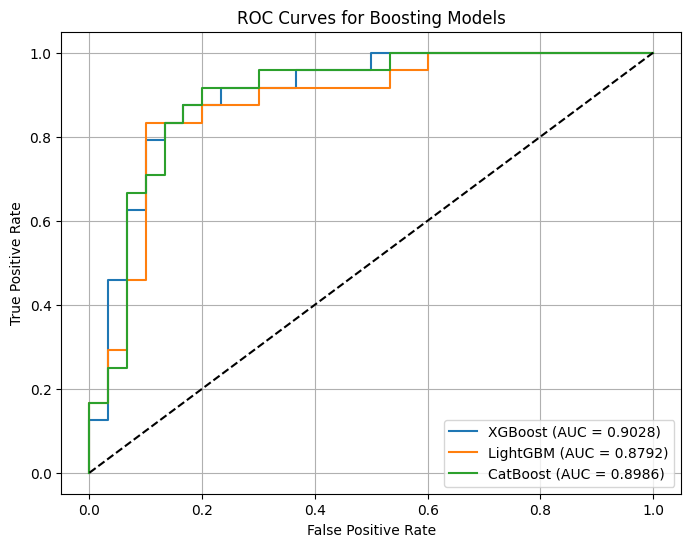

In [10]:
plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Boosting Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name}:\n{cm}\n")


XGBoost:
[[25  5]
 [ 4 20]]

LightGBM:
[[24  6]
 [ 3 21]]

CatBoost:
[[25  5]
 [ 3 21]]



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [12]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Таблица метрик
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "ROC AUC": roc_auc
    })

# Создание и отображение DataFrame с результатами
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by="F1 Score", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)

metrics_df

# немного странно что все кроме roc auc идентично, но списываю на то что датасет слишком мал

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,F1 Score,Precision,Recall (Sensitivity),Specificity,ROC AUC
0,CatBoost,0.851852,0.840000,0.807692,0.875000,0.833333,0.898611
1,LightGBM,0.833333,0.823529,0.777778,0.875000,0.800000,0.879167
2,XGBoost,0.833333,0.816327,0.800000,0.833333,0.833333,0.902778


## Тестируем лучшую модельку

=== CatBoost Final Evaluation ===
Accuracy: 0.8518518518518519
F1 Score: 0.84
Precision: 0.8076923076923077
Recall: 0.875
ROC AUC: 0.8986111111111111

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.81      0.88      0.84        24

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



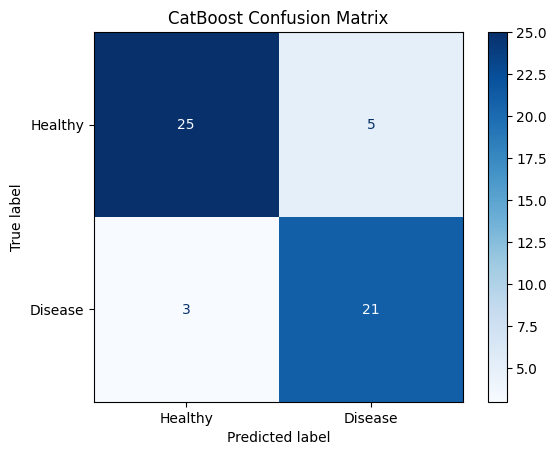

In [13]:
# Проверяем катбустовую модель - у нее получше точность и F1 (но ROC как то чуть хуже)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = best_models["CatBoost"]

X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Предсказания
y_pred = model.predict(X_test_df)
y_proba = model.predict_proba(X_test_df)[:, 1]

# Метрики
print("=== CatBoost Final Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Disease"])
disp.plot(cmap="Blues")
plt.title("CatBoost Confusion Matrix")
plt.grid(False)
plt.show()



# Добавим немножко оптимизаций

In [14]:
def objective_catboost(trial):
    params = {
        'loss_function': 'Logloss',
        'random_state': 42,
        'verbose': 0,
        'iterations': trial.suggest_int('iterations', 300, 1200),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 2.0),
    }

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', CatBoostClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=25, show_progress_bar=False)

study.best_params, study.best_value


optuna_params = study.best_params.copy()
optuna_params.update({'loss_function': 'Logloss', 'random_state': 42, 'verbose': 0})

cat_optuna = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', CatBoostClassifier(**optuna_params))
])

cat_optuna.fit(X_train, y_train)

y_pred_opt = cat_optuna.predict(X_test_df)
y_proba_opt = cat_optuna.predict_proba(X_test_df)[:, 1]

acc_o = accuracy_score(y_test, y_pred_opt)
f1_o  = f1_score(y_test, y_pred_opt)
prec_o = precision_score(y_test, y_pred_opt)
rec_o = recall_score(y_test, y_pred_opt)
roc_o = roc_auc_score(y_test, y_proba_opt)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
spec_o = tn / (tn + fp)

print("CatBoost (Optuna) — Test metrics")
print(f"Accuracy: {acc_o:.4f} | F1: {f1_o:.4f} | Precision: {prec_o:.4f} | Recall: {rec_o:.4f} | Specificity: {spec_o:.4f} | ROC AUC: {roc_o:.4f}")

joblib.dump(cat_optuna, "CatBoost_optuna_best.pkl")


[I 2025-08-09 10:20:57,500] A new study created in memory with name: no-name-9d7179a0-3778-496c-b569-22e5389b0421
[I 2025-08-09 10:21:30,268] Trial 0 finished with value: 0.7587522429261561 and parameters: {'iterations': 1033, 'depth': 9, 'learning_rate': 0.011176469394728427, 'l2_leaf_reg': 4.830948041878541, 'random_strength': 1.0760183251954358}. Best is trial 0 with value: 0.7587522429261561.
[I 2025-08-09 10:21:35,992] Trial 1 finished with value: 0.8137955323973562 and parameters: {'iterations': 869, 'depth': 5, 'learning_rate': 0.0011709334334824464, 'l2_leaf_reg': 1.698994309008443, 'random_strength': 0.3136682484949185}. Best is trial 1 with value: 0.8137955323973562.
[I 2025-08-09 10:21:39,428] Trial 2 finished with value: 0.8019402543626146 and parameters: {'iterations': 320, 'depth': 7, 'learning_rate': 0.002784040762265331, 'l2_leaf_reg': 3.5116240267938297, 'random_strength': 0.41421587276415117}. Best is trial 1 with value: 0.8137955323973562.
[I 2025-08-09 10:21:59,774]

CatBoost (Optuna) — Test metrics
Accuracy: 0.8519 | F1: 0.8333 | Precision: 0.8333 | Recall: 0.8333 | Specificity: 0.8667 | ROC AUC: 0.8986


['CatBoost_optuna_best.pkl']

In [15]:
extended = results_df.copy()

extended = pd.concat([
    extended,
    pd.DataFrame([{
        "Model": "CatBoost_Optuna",
        "Search": "optuna",
        "BestParams": optuna_params,
        "Test_Accuracy": acc_o,
        "Test_F1": f1_o,
        "Test_Precision": prec_o,
        "Test_Recall": rec_o,
        "Test_Specificity": spec_o,
        "Test_ROC_AUC": roc_o,
        "CV_Accuracy": np.nan,
        "CV_F1": np.nan
    }])
], ignore_index=True)

extended.sort_values(by="Test_F1", ascending=False).reset_index(drop=True)


,Model,Search,BestParams,Test_Accuracy,Test_F1,Test_Precision,Test_Recall,Test_Specificity,Test_ROC_AUC,CV_Accuracy,CV_F1
0,CatBoost,random,"{'model__random_strength': 2, 'model__learning...",0.851852,0.840000,0.807692,0.875000,0.833333,0.898611,0.844444,0.818757
1,CatBoost_Optuna,optuna,"{'iterations': 1170, 'depth': 6, 'learning_rat...",0.851852,0.833333,0.833333,0.833333,0.866667,0.898611,NaN,NaN
2,LightGBM,random,"{'model__subsample': 1.0, 'model__num_leaves':...",0.833333,0.823529,0.777778,0.875000,0.800000,0.879167,0.814815,0.786369
3,XGBoost,random,"{'model__subsample': 0.7, 'model__n_estimators...",0.833333,0.816327,0.800000,0.833333,0.833333,0.902778,0.822222,0.793272


# В сухом остатке

## Данные
Использован датасет **UCI Statlog (Heart)** (270 наблюдений, 13 признаков). Целевая переменная была преобразована: из {1, 2} в {0, 1}, где 1 — наличие заболевания.

## Подход
1) Проведён EDA: проверены пропуски, распределение целевого класса, корреляции признаков.  
2) Построены пайплайны `sklearn` с предобработкой (`SimpleImputer`, `StandardScaler`) и моделями: XGBoost, LightGBM, CatBoost.  
3) Подбор гиперпараметров выполнен двумя способами:
   - GridSearchCV с расширенными сетками,
   - RandomizedSearchCV (ускоренный перебор случайных комбинаций).

4) Показан пример оптимизации гиперпараметров CatBoost с помощью **Optuna** (25 итераций). Результат лучше не получился

5) Оценка по Accuracy, F1, Precision, Recall, Specificity, ROC AUC. Построены ROC-кривые.

6) Лучшие модели сохранены с помощью `joblib`.

## Основные результаты
- Итоговые метрики по тесту сведены в таблицу `extended` (сравнение моделей и Optuna-версии CatBoost).
- ROC-кривые демонстрируют сопоставимое качество бустинговых моделей на данном небольшом наборе. (но CatBoost как будто чуть получше - просто датасет очень мелкий)
- Расширение сеток и использование RandomizedSearch позволило получить более разнообразные конфигурации моделей.
- Пример **Optuna** показал, как автоматизировать и ускорить поиск параметров при ограниченном времени.

## Выводы
- На небольших датасетах (как Statlog) бустинговые модели могут давать близкие результаты; в этом случае важны:
  - корректная валидация (Stratified K-Fold),
  - тщательный выбор метрик (F1 и ROC AUC),
  - поиск гиперпараметров с разумными границами.
